Vamos a poder seleccionar para el entrenamiento sobre todas las características que queramos.  

In [141]:
import sys 
BASE_DIR="/home/arturosf/Documentos/repos/second_CTA_analysis"
sys.path.append(f"{BASE_DIR}/src/CTA-data-analisis-library/")
import numpy as np 
import matplotlib.pyplot as plt
import os 
import re 
import glob 
import tensorflow as tf 
import seaborn as sns
import pandas as pd

#propias
import unzipdata_and_first_treatments as manipulate
import loaddata4use
import model_creation_functions as models

In [2]:
PATH_TXT=f"{BASE_DIR}/data_full/combined/SimTelArray_2022_05"


In [3]:
list_aux=glob.glob(f"{PATH_TXT}/extract_electron/*.txt")
list_aux=sorted(list_aux)
print(len(list_aux))

1460


In [4]:
#La idea es tener un diccionario enorme de todo lo que podemos necesitar para seleccionar el rango de todo y las distribuciones.  
# Esto lo logramos con los datos de extract  
aux=loaddata4use.extract_info_txt(list_aux[1455])
list_aux[1455]

'/home/arturosf/Documentos/repos/second_CTA_analysis/data_full/combined/SimTelArray_2022_05/extract_electron/electron_tel_4_run_366.txt'

(591, 26)


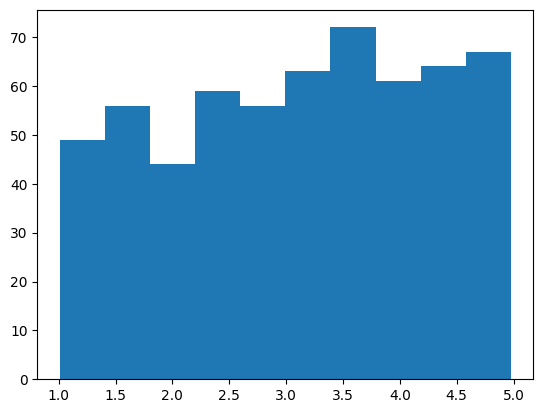

In [5]:
plt.hist(aux[:,2])
print(aux.shape)

In [6]:
cols_names=["event"
,"telescope"
,"energy"
,"core distance to telescope"
,"image size (amplitude) [p.e.]"
,"number of pixels in image"
,"width [deg.]"
,"length [deg.]"
,"distance [deg.]"
,"miss [deg.]"
,"alpha [deg.]"
,"orientation [deg.]"
,"direction [deg.]"
,"image c.o.g. x [deg.]"
,"image c.o.g. y [deg.]"
,"Xmax [g/cm^2]"
,"Hmax [m]"
,"Npe (true number of photo-electrons)"
,"(19-23): Hottest pixel amplitudes)"]
len(cols_names)

19

Tengo todas las runs y todos los eventos con sus respectivas runs. Voy a hacer lo siguiente.  
- Tomaré todos los eventos disponibles para una distribución uniforme de energias ,y haré tanto la clasificacion como la regresión de energías. Con los mismo RUNS para el train y luego test unos diferentes que para train, pero los mismos entre clasificación y regresion.  


In [7]:
archivo_min_pares = [1, 1, 1, 1, 1, 1, 1]
archivo_min_indices_pares = [91, 361, 421, 309, 387, 347, 417]
archivo_max_pares = [90, 360, 420, 308, 386, 346, 416]
archivo_max_indices_pares = [100, 370, 430, 320, 400, 360, 434]


Tenemos la info de cada run y todos los elementos, y lo que nos gustaria es elegir unas cuantas runs y saber para cada elemento, que distribucion de energias tenemos.  

In [8]:
list_aux[0]

'/home/arturosf/Documentos/repos/second_CTA_analysis/data_full/combined/SimTelArray_2022_05/extract_electron/electron_tel_1_run_001.txt'

In [9]:
int(re.findall("(\d{3})\.txt",list_aux[0])[0])

1

In [10]:
# voy a cargar toda la info de los txt para cada elemento 
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
aux2=[]
for i , elemento in enumerate(elementos):
    #dict_master[elemento]={}
    list_aux=glob.glob(f"{PATH_TXT}/extract_{elemento}/*.txt")
    list_aux=sorted(list_aux)

    for dir_aux in list_aux:
        run_aux=int(re.findall("(\d{3})\.txt",dir_aux)[0])
        tel_aux=int(re.findall("tel_(\d{1})_run",dir_aux)[0])
        #La idea es tener un diccionario enorme de todo lo que podemos necesitar para seleccionar el rango de todo y las distribuciones.  
        # Esto lo logramos con los datos de extract  
        array_aux=loaddata4use.extract_info_txt(dir_aux)
        if array_aux.size>0:
            aux2.append({"elemento":elemento,"run":run_aux,"tel":tel_aux,"energia":array_aux[:,2],"eventos":array_aux[:,0].astype(int)})
        else:
            aux2.append({"elemento":elemento,"run":run_aux,"tel":tel_aux,"energia":np.nan,"eventos":np.nan})
df_final=pd.DataFrame.from_dict(aux2)
    
df_final

,elemento,run,tel,energia,eventos
0,gamma,1,1,"[0.1087, 0.0616, 0.0904, 4.5563, 0.3297, 0.057...","[800, 1200, 1700, 2300, 3600, 4200, 4300, 5200..."
1,gamma,2,1,"[0.0957, 0.0321, 0.2691, 0.0559, 0.2708, 1.74,...","[100, 400, 700, 2100, 2500, 3100, 3300, 3500, ..."
2,gamma,3,1,NaN,NaN
3,gamma,4,1,"[0.0424, 0.1245, 0.0328, 0.0341, 1.0774, 0.070...","[100, 200, 700, 1800, 2200, 2600, 3500, 3900, ..."
4,gamma,5,1,"[0.2236, 0.2041, 0.0704, 0.1473, 0.0458, 0.095...","[200, 600, 800, 1000, 1700, 1900, 3500, 3600, ..."
...,...,...,...,...,...
9628,silicon,356,4,"[4.4503, 4.3298, 3.8065, 4.5505, 4.7329, 3.959...","[4100, 6900, 7800, 10100, 10200, 11600, 13800,..."
9629,silicon,357,4,"[3.2706, 4.7084, 4.9035, 3.0785, 3.5371, 4.756...","[400, 1200, 2100, 7400, 9300, 10700, 11700, 13..."
9630,silicon,358,4,"[4.8596, 4.8966, 2.2676, 4.0688, 4.3492, 2.959...","[700, 2700, 8300, 9000, 15400, 16300, 20500, 2..."
9631,silicon,359,4,"[2.1081, 2.8272, 3.8519, 2.8368, 4.525, 3.0555...","[1700, 3900, 5300, 6700, 11300, 12400, 14300, ..."


In [11]:
df_final.groupby(["elemento","run"]).apply(lambda x : pd.Series([False]*x.shape[0]) if x["eventos"].isna().any() else pd.Series([True]*x.shape[0]))==False

elemento  run   
electron  1    0    False
               1    False
               2    False
               3    False
          2    0    False
                    ...  
silicon   359  3    False
          360  0    False
               1    False
               2    False
               3    False
Length: 9633, dtype: bool

In [12]:
df_clean=df_final.groupby(["elemento","run"]).apply(lambda x: x if len(list(x["tel"]))==4 else print(list(x["tel"]))).dropna().reset_index(drop=True)

[1, 2, 3]
[1, 3, 4]
[1, 2, 3]
[1, 3, 4]
[1, 3, 4]
[1, 2, 3]
[1, 3, 4]
[1, 3, 4]
[1, 3, 4]
[1, 3, 4]
[1, 2, 3]
[1, 2, 4]
[2, 3, 4]
[1, 3, 4]
[1, 2, 3]
[1, 3, 4]
[1, 2, 4]
[1, 2, 4]
[1, 2, 4]
[1, 2, 3]
[1, 2, 3]
[1, 2, 4]
[1, 2, 4]


In [13]:
df_clean

,elemento,run,tel,energia,eventos
0,electron,1,1,"[0.7343, 0.2967, 0.1307, 0.2604, 0.1603, 0.052...","[21200, 35900, 55300, 61000, 74000, 74800, 752..."
1,electron,1,2,"[0.1307, 0.1603, 0.0522, 0.0365, 0.0358, 0.803...","[55300, 74000, 74800, 77500, 77700, 82500, 894..."
2,electron,1,3,"[0.2227, 0.1307, 0.1603, 0.1108, 0.0358, 0.803...","[800, 55300, 74000, 75200, 77700, 82500, 10600..."
3,electron,1,4,"[0.2227, 0.7343, 0.2967, 0.1307, 0.2604, 0.161...","[800, 21200, 35900, 55300, 61000, 62300, 74000..."
4,electron,2,1,"[0.0566, 0.0508, 0.0656, 1.5473, 0.7692, 0.529...","[13900, 35800, 47100, 50700, 54300, 63600, 638..."
...,...,...,...,...,...
9535,silicon,359,4,"[2.1081, 2.8272, 3.8519, 2.8368, 4.525, 3.0555...","[1700, 3900, 5300, 6700, 11300, 12400, 14300, ..."
9536,silicon,360,1,"[4.6059, 3.8817, 4.4777, 2.9524, 2.7399, 4.324...","[1700, 4500, 4900, 5900, 6500, 7100, 7200, 760..."
9537,silicon,360,2,"[4.6059, 3.8379, 3.8817, 4.4777, 2.9524, 2.739...","[1700, 3800, 4500, 4900, 5900, 6500, 7100, 720..."
9538,silicon,360,3,"[4.6059, 3.8379, 3.8817, 4.4777, 2.9524, 4.626...","[1700, 3800, 4500, 4900, 5900, 7600, 9100, 132..."


In [33]:
def f_get_comon_events(df):
    all_eventos=np.concatenate(df["eventos"].to_numpy())
    event,count=np.unique(all_eventos,return_counts=True)
    all_energias=np.concatenate(df["energia"].to_numpy())
    energias_eventos_comunes=[]
    for i in event[count==4]:
        indx=np.argwhere(i==all_eventos)
        if np.unique(all_energias[indx]).size!=1:
            print("Algo ha pasado con el evento i, no coinciden las energias")
        energias_eventos_comunes.append(all_energias[indx[0]][0])
    return pd.DataFrame({"eventos":event[count==4],"energia":energias_eventos_comunes})

In [34]:
df_common_events=df_clean.groupby(["elemento","run"]).apply(f_get_comon_events).droplevel(2).reset_index()#.to_frame()
#df_common_events.columns=["eventos"]
df_common_events

,elemento,run,eventos,energia
0,electron,1,55300,0.1307
1,electron,1,74000,0.1603
2,electron,1,82500,0.8038
3,electron,1,109700,0.6685
4,electron,1,152100,0.2394
...,...,...,...,...
601768,silicon,360,1796100,4.8594
601769,silicon,360,1798300,2.8470
601770,silicon,360,1798500,4.9862
601771,silicon,360,1798800,4.4138


In [35]:
df_common_events.groupby("elemento").size()

elemento
electron     86277
gamma       116135
helium       81928
iron         71055
nitrogen     87882
proton       72290
silicon      86206
dtype: int64

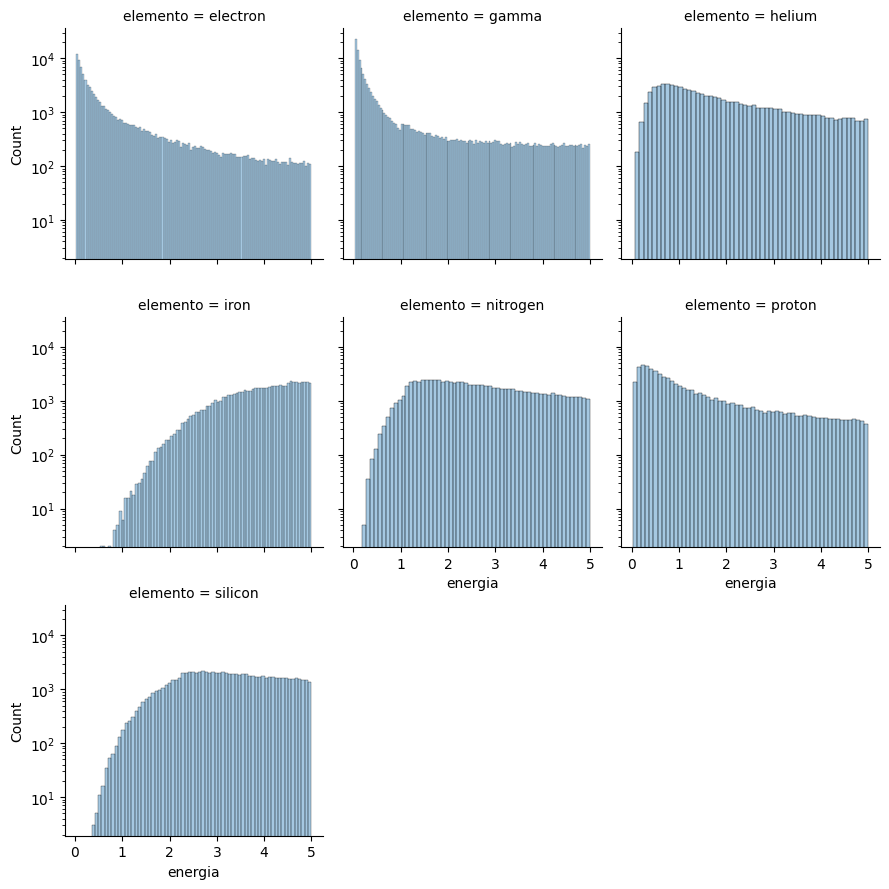

In [52]:
g = sns.FacetGrid(df_common_events, col="elemento",col_wrap=3 )
g.map(sns.histplot,"energia", alpha=.4,log_scale=[False,True])

In [53]:
df_common_events

,elemento,run,eventos,energia
0,electron,1,55300,0.1307
1,electron,1,74000,0.1603
2,electron,1,82500,0.8038
3,electron,1,109700,0.6685
4,electron,1,152100,0.2394
...,...,...,...,...
601768,silicon,360,1796100,4.8594
601769,silicon,360,1798300,2.8470
601770,silicon,360,1798500,4.9862
601771,silicon,360,1798800,4.4138


In [72]:
elementos=['gamma', 'electron', 'proton', 'helium', 'nitrogen', 'silicon', 'iron']

elemento
electron    82019
gamma       96498
helium      75907
iron        66471
nitrogen    81907
proton      67707
silicon     80742
dtype: int64


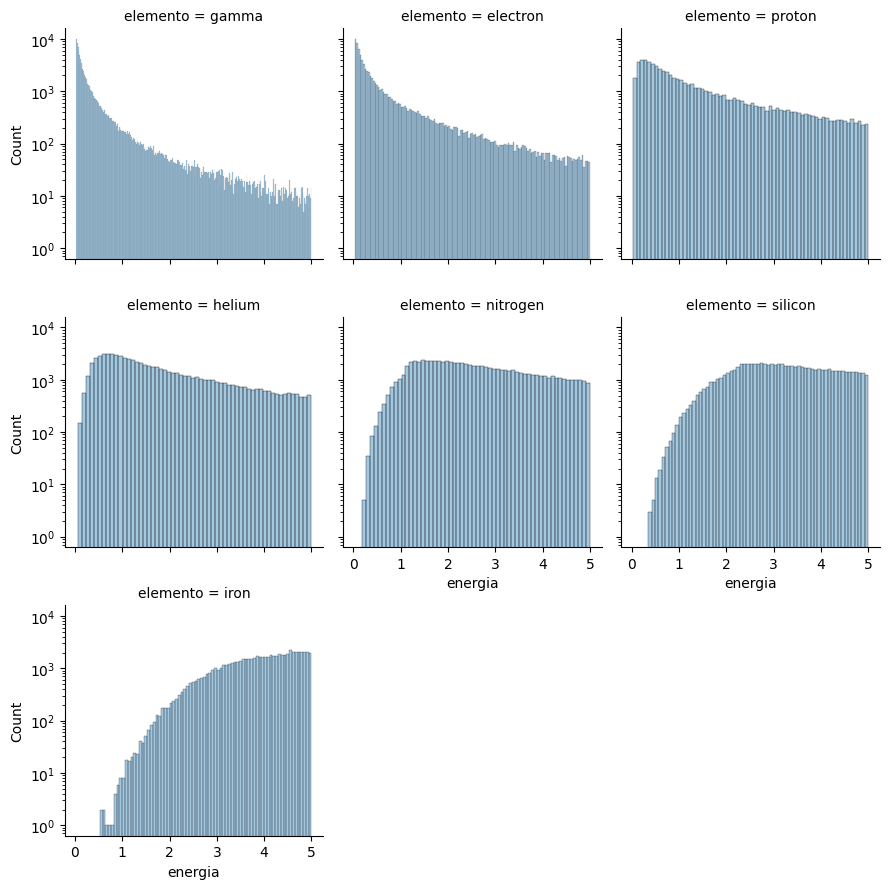

In [71]:
# vamos a hacerlo para los eventos antes y despues del cambio ese de la simulacion  

#estos siguen este orden -> ['gamma', 'electron', 'proton', 'helium', 'nitrogen', 'silicon', 'iron']
archivo_min_pares = [1, 1, 1, 1, 1, 1, 1]
archivo_min_indices_pares = [91, 361, 421, 309, 387, 347, 417]
archivo_max_pares = [90, 360, 420, 308, 386, 346, 416]
archivo_max_indices_pares = [100, 370, 430, 320, 400, 360, 434]

aux_df=[]
for j,i in enumerate(elementos):
    element_aux_df=df_common_events.loc[df_common_events["elemento"]==i]
    aux_df.append(element_aux_df.loc[(element_aux_df["run"]>=archivo_min_pares[j])&(element_aux_df["run"]<=archivo_max_pares[j])])
df_common_events_aux1=pd.concat(aux_df)
print(df_common_events_aux1.groupby("elemento").size())

g = sns.FacetGrid(df_common_events_aux1, col="elemento",col_wrap=3 )
g.map(sns.histplot,"energia", alpha=.4,log_scale=[False,True])

elemento
electron     4258
gamma       19637
helium       6021
iron         4584
nitrogen     5975
proton       4583
silicon      5464
dtype: int64


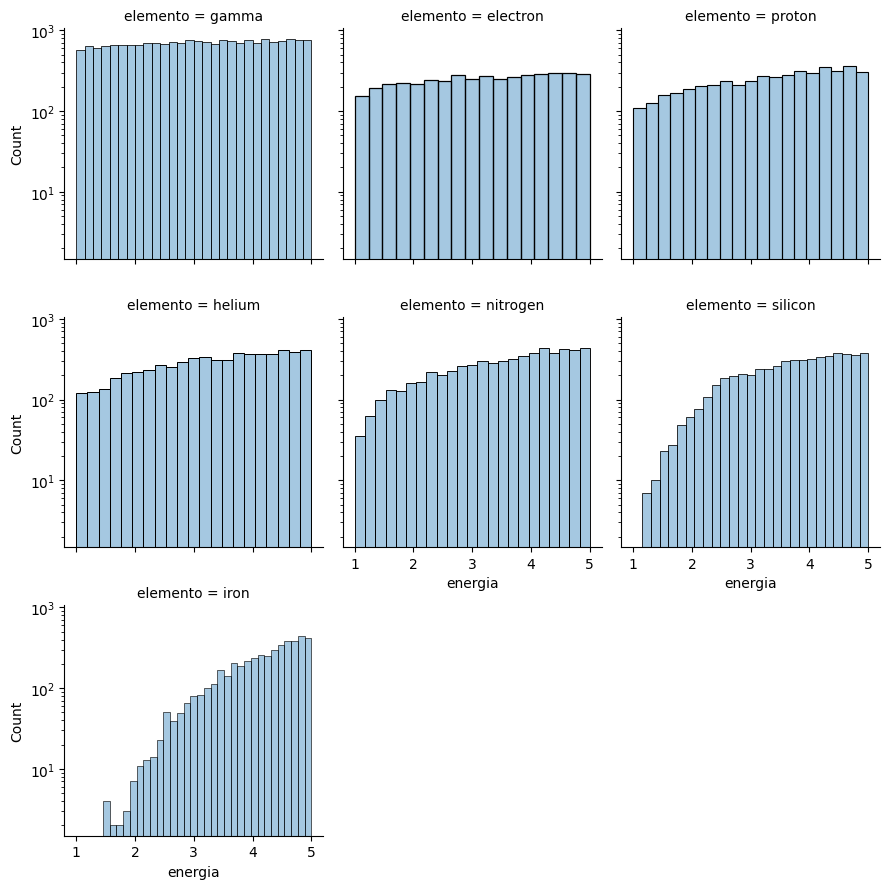

In [73]:
aux_df=[]
for j,i in enumerate(elementos):
    element_aux_df=df_common_events.loc[df_common_events["elemento"]==i]
    aux_df.append(element_aux_df.loc[(element_aux_df["run"]>=archivo_min_indices_pares[j])&(element_aux_df["run"]<=archivo_max_indices_pares[j])])
df_common_events_aux1=pd.concat(aux_df)
print(df_common_events_aux1.groupby("elemento").size())
g = sns.FacetGrid(df_common_events_aux1, col="elemento",col_wrap=3 )
g.map(sns.histplot,"energia", alpha=.4,log_scale=[False,True])

elemento
electron     86277
gamma       116135
helium       81928
iron         71055
nitrogen     87882
proton       72290
silicon      86206
dtype: int64


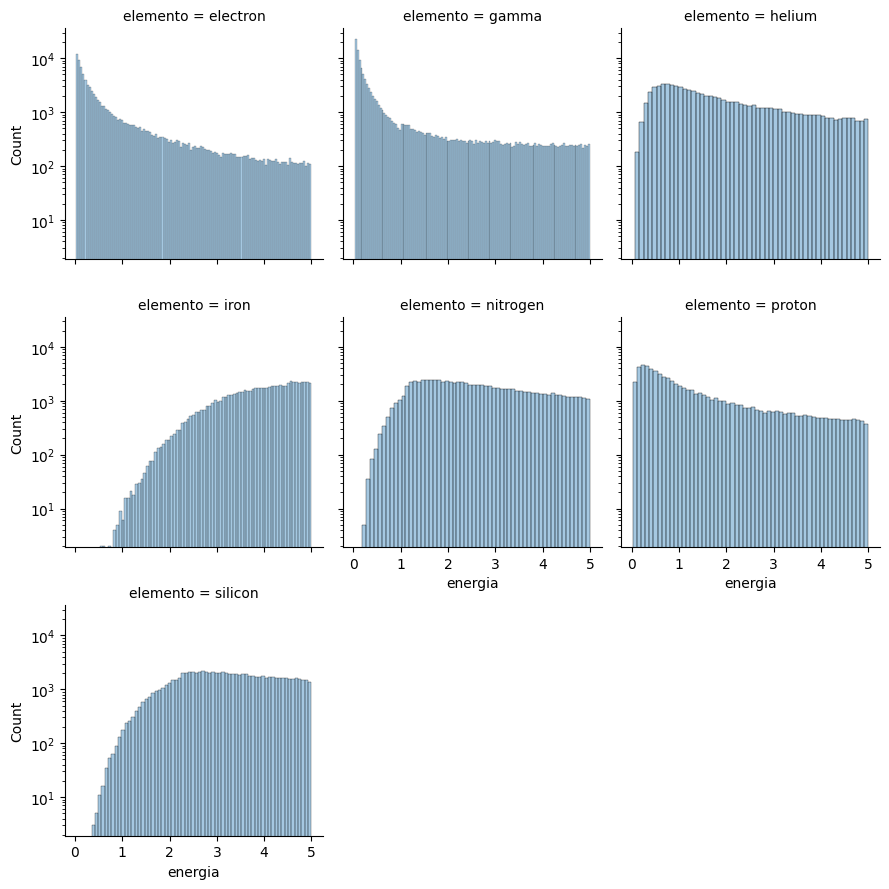

In [75]:
g = sns.FacetGrid(df_common_events, col="elemento",col_wrap=3 )
g.map(sns.histplot,"energia", alpha=.4,log_scale=[False,True])
print(df_common_events.groupby("elemento").size())


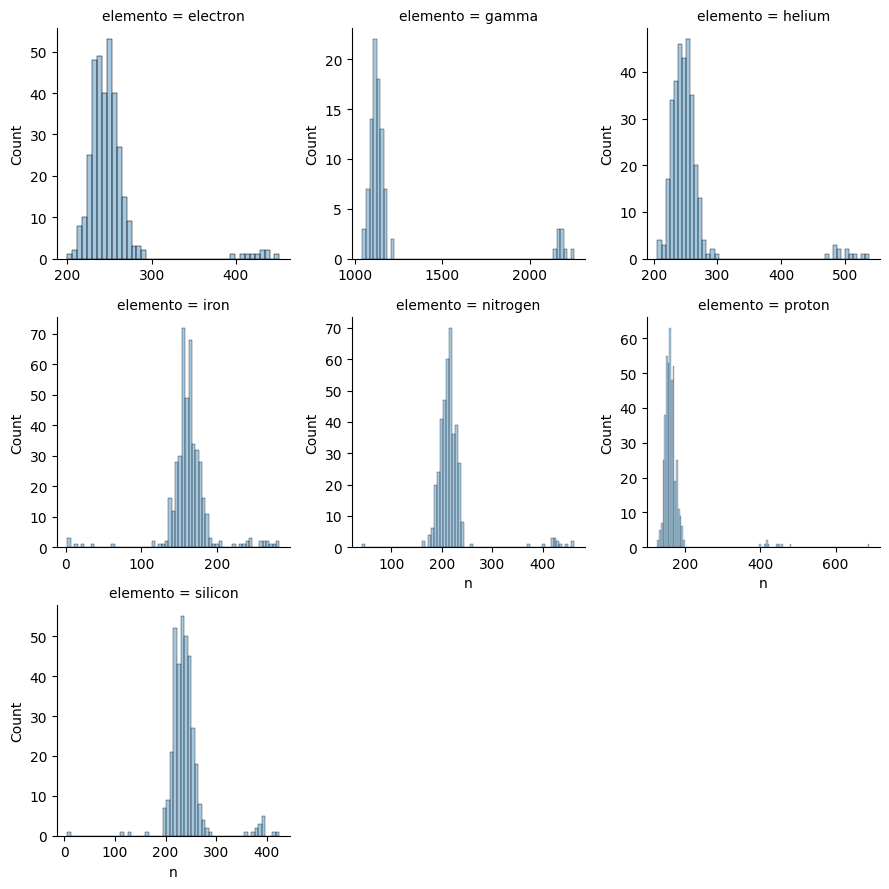

In [89]:
eventos_number=df_common_events.groupby(["elemento","run"]).size().to_frame().reset_index()
eventos_number=eventos_number.rename(columns={0:"n"})
g = sns.FacetGrid(eventos_number, col="elemento",col_wrap=3,sharex=False,sharey=False )
g.map(sns.histplot,"n", alpha=.4)

In [101]:
#vamos a seleccionar unas runs para el train y otras para el test   
eventos_number_rand=eventos_number.groupby("elemento").apply(lambda x : x.sample(frac=1)).reset_index(drop=True)
eventos_number_rand

,elemento,run,n
0,electron,288,255
1,electron,154,270
2,electron,157,248
3,electron,88,265
4,electron,370,440
...,...,...,...
2379,silicon,295,235
2380,silicon,333,227
2381,silicon,97,221
2382,silicon,39,248


In [107]:
eventos_number_rand["percent"]=eventos_number_rand.groupby("elemento")["n"].transform(lambda x : x/x.sum())
eventos_number_rand

,elemento,run,n,percent
0,electron,288,255,0.002956
1,electron,154,270,0.003129
2,electron,157,248,0.002874
3,electron,88,265,0.003072
4,electron,370,440,0.005100
...,...,...,...,...
2379,silicon,295,235,0.002726
2380,silicon,333,227,0.002633
2381,silicon,97,221,0.002564
2382,silicon,39,248,0.002877


In [112]:
eventos_number_rand["cumsum"]=eventos_number_rand.groupby("elemento")["percent"].transform(lambda x : x.cumsum())
eventos_number_rand

,elemento,run,n,percent,cumsum
0,electron,288,255,0.002956,0.002956
1,electron,154,270,0.003129,0.006085
2,electron,157,248,0.002874,0.008960
3,electron,88,265,0.003072,0.012031
4,electron,370,440,0.005100,0.017131
...,...,...,...,...,...
2379,silicon,295,235,0.002726,0.988899
2380,silicon,333,227,0.002633,0.991532
2381,silicon,97,221,0.002564,0.994096
2382,silicon,39,248,0.002877,0.996972


In [127]:
#ahora para cada elemento, vamos a guardar los runs que contienen el 80% de los datos
eventos_number_rand.loc[eventos_number_rand["cumsum"]<0.80,"mode"]="Train"
eventos_number_rand["mode"]=eventos_number_rand["mode"].fillna("Test")
eventos_number_rand


,elemento,run,n,percent,cumsum,mode
0,electron,288,255,0.002956,0.002956,Train
1,electron,154,270,0.003129,0.006085,Train
2,electron,157,248,0.002874,0.008960,Train
3,electron,88,265,0.003072,0.012031,Train
4,electron,370,440,0.005100,0.017131,Train
...,...,...,...,...,...,...
2379,silicon,295,235,0.002726,0.988899,Test
2380,silicon,333,227,0.002633,0.991532,Test
2381,silicon,97,221,0.002564,0.994096,Test
2382,silicon,39,248,0.002877,0.996972,Test


In [132]:
eventos_number_rand.groupby(["elemento","mode"]).size()/eventos_number_rand.groupby(["elemento"]).size()


elemento  mode 
electron  Test     0.205797
          Train    0.794203
gamma     Test     0.189474
          Train    0.810526
helium    Test     0.193750
          Train    0.806250
iron      Test     0.200461
          Train    0.799539
nitrogen  Test     0.202500
          Train    0.797500
proton    Test     0.206977
          Train    0.793023
silicon   Test     0.205556
          Train    0.794444
dtype: float64

In [147]:
df_lista_runs=eventos_number_rand.groupby(["elemento","mode"]).apply(lambda x : list(x["run"])).to_frame(name="list_runs").reset_index()
df_lista_runs

,elemento,mode,list_runs
0,electron,Test,"[344, 260, 308, 127, 151, 208, 121, 272, 315, ..."
1,electron,Train,"[288, 154, 157, 88, 370, 338, 175, 246, 1, 115..."
2,gamma,Test,"[86, 43, 25, 10, 66, 36, 95, 57, 72, 82, 79, 3..."
3,gamma,Train,"[32, 53, 99, 11, 9, 23, 4, 75, 30, 7, 41, 8, 2..."
4,helium,Test,"[60, 290, 293, 152, 118, 289, 305, 223, 208, 1..."
5,helium,Train,"[73, 112, 195, 301, 203, 268, 135, 88, 292, 76..."
6,iron,Test,"[329, 71, 278, 135, 287, 129, 354, 392, 381, 2..."
7,iron,Train,"[321, 339, 202, 99, 69, 95, 427, 334, 250, 170..."
8,nitrogen,Test,"[383, 72, 178, 337, 42, 374, 213, 245, 261, 22..."
9,nitrogen,Train,"[397, 365, 264, 253, 386, 79, 156, 185, 111, 1..."


In [168]:
elementos=['gamma', 'electron', 'proton', 'helium', 'nitrogen', 'silicon', 'iron']
train_runs=df_lista_runs.loc[df_lista_runs["mode"]=="Train"].set_index("elemento")
train_runs=train_runs.loc[elementos].reset_index()
train_runs_list=list(train_runs["list_runs"].to_numpy())
print(len(train_runs_list),[len(i) for i in train_runs_list])
train_runs

7 [77, 274, 341, 258, 319, 286, 347]


,elemento,mode,list_runs
0,gamma,Train,"[32, 53, 99, 11, 9, 23, 4, 75, 30, 7, 41, 8, 2..."
1,electron,Train,"[288, 154, 157, 88, 370, 338, 175, 246, 1, 115..."
2,proton,Train,"[240, 42, 51, 122, 188, 403, 26, 247, 60, 279,..."
3,helium,Train,"[73, 112, 195, 301, 203, 268, 135, 88, 292, 76..."
4,nitrogen,Train,"[397, 365, 264, 253, 386, 79, 156, 185, 111, 1..."
5,silicon,Train,"[337, 61, 261, 299, 200, 23, 31, 338, 332, 341..."
6,iron,Train,"[321, 339, 202, 99, 69, 95, 427, 334, 250, 170..."


In [169]:
test_runs=df_lista_runs.loc[df_lista_runs["mode"]=="Test"].set_index("elemento")
test_runs=test_runs.loc[elementos].reset_index()
test_runs_list=list(test_runs["list_runs"].to_numpy())
print(len(test_runs_list),[len(i) for i in test_runs_list])
test_runs

7 [18, 71, 89, 62, 81, 74, 87]


,elemento,mode,list_runs
0,gamma,Test,"[86, 43, 25, 10, 66, 36, 95, 57, 72, 82, 79, 3..."
1,electron,Test,"[344, 260, 308, 127, 151, 208, 121, 272, 315, ..."
2,proton,Test,"[407, 83, 201, 24, 95, 331, 152, 278, 362, 284..."
3,helium,Test,"[60, 290, 293, 152, 118, 289, 305, 223, 208, 1..."
4,nitrogen,Test,"[383, 72, 178, 337, 42, 374, 213, 245, 261, 22..."
5,silicon,Test,"[250, 112, 87, 272, 124, 48, 137, 209, 33, 156..."
6,iron,Test,"[329, 71, 278, 135, 287, 129, 354, 392, 381, 2..."


## La parte del entrenamiento con esas runs 

In [170]:
PATH_npy=f"{BASE_DIR}/data_full/combined/elementos_npy"
PATH_npy

'/home/arturosf/Documentos/repos/second_CTA_analysis/data_full/combined/elementos_npy'

In [172]:
os.listdir(PATH_npy)

['npy_iron',
 'npy_silicon',
 'npy_gamma',
 'npy_proton',
 'npy_nitrogen',
 'npy_electron',
 'npy_helium']

In [166]:
train_runs

,elemento,mode,list_runs
0,gamma,Train,"[32, 53, 99, 11, 9, 23, 4, 75, 30, 7, 41, 8, 2..."
1,electron,Train,"[288, 154, 157, 88, 370, 338, 175, 246, 1, 115..."
2,proton,Train,"[240, 42, 51, 122, 188, 403, 26, 247, 60, 279,..."
3,helium,Train,"[73, 112, 195, 301, 203, 268, 135, 88, 292, 76..."
4,nitrogen,Train,"[397, 365, 264, 253, 386, 79, 156, 185, 111, 1..."
5,silicon,Train,"[337, 61, 261, 299, 200, 23, 31, 338, 332, 341..."
6,iron,Train,"[321, 339, 202, 99, 69, 95, 427, 334, 250, 170..."


In [175]:
x_train_list,x_test_list,y_train_list,y_test_list=loaddata4use.load_dataset_completo(PATH_npy,labels_asign=[0,1,2,2,2,2,2],elements=elementos,
                                                                                    main_list_runs=train_runs_list,pre_name_folders="npy_",telescopes=[1,2,3,4],
                                                                                    test_size=0.1,same_quant="all",verbose=True,fill=True,categorical=True)



Load of names and common events
_______________
ERROR
Para npy_gamma no se encuentra el id_eventos_*_tel_4_run_032.npy.


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
x_train_list=cambiar_ejes_lista(x_train_list)
x_test_list=cambiar_ejes_lista(x_test_list)

In [ ]:
file_number="012"
n=19 #repes de boostrap
#primer bucle para arquitecturas
for i,arch in enumerate(opciones_filtros):
    print(f"{i}: {arch} \n")
    modelo=models.model_multi_tel(classes=3,filtros=arch,last_dense=[20,5])
    modelo.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc","AUC","mean_squared_error"])
    with open(f"{base_dir}/automat/logs/{file_number}_data_control.txt","a") as registro:
        registro.write(f"Con arquitectura: {arch} : \n")

    #segundo_bucle para boostrap
    for k in range(n):
        print(f"\n Boostrap {k+1} de {n}")

        #list_runs=new_create_main_list_runs([8,35,24,24,24,24,24],chose_runs)
        list_runs=new_create_main_list_runs([1,1,1,1,1,1,1],chose_runs)
        with open(f"{base_dir}/automat/logs/{file_number}_data_control.txt","a") as registro:
            registro.write(f"Boostrap {k+1} de {n},runs: {list_runs}, \n")
        x_train_list,x_test_list,y_train_list,y_test_list=loaddata4use.load_dataset_completo(npy_final_dir,labels_asign=[0,1,2,2,2,2,2],elements=elements,
                                                                                            main_list_runs=list_runs,pre_name_folders="npy_",telescopes=[1,2,3,4],
                                                                                            test_size=0.3,same_quant="same",verbose=True,fill=True,categorical=True)
        x_train_list=cambiar_ejes_lista(x_train_list)
        x_test_list=cambiar_ejes_lista(x_test_list)

        
        hist=modelo.fit(x=x_train_list,y=y_train_list,epochs=45, validation_data=(x_test_list,y_test_list),batch_size=64)            
        gc.collect()
        del x_train_list,x_test_list,y_train_list,y_test_list
        modelo.save(f"{base_dir}/modelos/{file_number}_modelo_filtro_{i}_en_boostrap_stage_{k+1}.h5")
        with open(f"{base_dir}/modelos/performances/{file_number}_history_modelo_filtro_{i}_en_boostrap_stage_{k+1}.pickle","wb") as pick:
            pickle.dump(hist,pick)
    gc.collect()
    del modelo 
    tf.keras.backend.clear_session()
    device.reset()
